# UNI-USD ARIMA MODEL

An ARIMA model is characterized by 3 terms: p, d, q

where, <br>
p is the order of the AR term -- refers to the number of lags of Y to be used as predictors. <br>
q is the order of the MA term -- refers to the number of lagged forecast errors that should go into the ARIMA Model. <br>
d is the number of differencing required to make the time series stationary

# What are AR and MA models

A pure Auto Regressive (AR only) model is one where Yt depends only on its own lags. That is, Yt is a function of the ‘lags of Yt’.

A pure Moving Average (MA only) model is one where Yt depends only on the lagged forecast errors.  Where the error terms are the errors of the autoregressive models of the respective lags. 

Putting these together, an ARIMA model in words: 

Predicted Yt = Constant + Linear combination Lags of Y(upto n lags) + Linear Combination of Lagged forecast errors(upto n lags)

# How to find the order of differencing (d) in ARIMA model

The right order of differencing is the minimum differencing required to get a near-stationary series which roams around a defined mean and the ACF plot reaches to zero fairly quick.  This can be done with statsmodels adfuller()

In [1]:
from statsmodels.tsa.stattools import adfuller
from numpy import log
import pandas as pd
import sys

sys.path.insert(0, r'C:\Users\user\Scripts\TimeseriesFunctions')
sys.path.insert(0, r'C:\Users\user\Scripts\Crypto\crypto_ohlcv-master')
from timeseries_functions import *

df = pd.read_csv(r'C:\Users\user\Scripts\Crypto\crypto_ohlcv-master\UNI-USD.csv')
df['value'] = df.close


result = adfuller(df.value.dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -1.552398
p-value: 0.507450


Since P-value is greater than the significance level, let’s difference the series and see how the autocorrelation plot looks like.

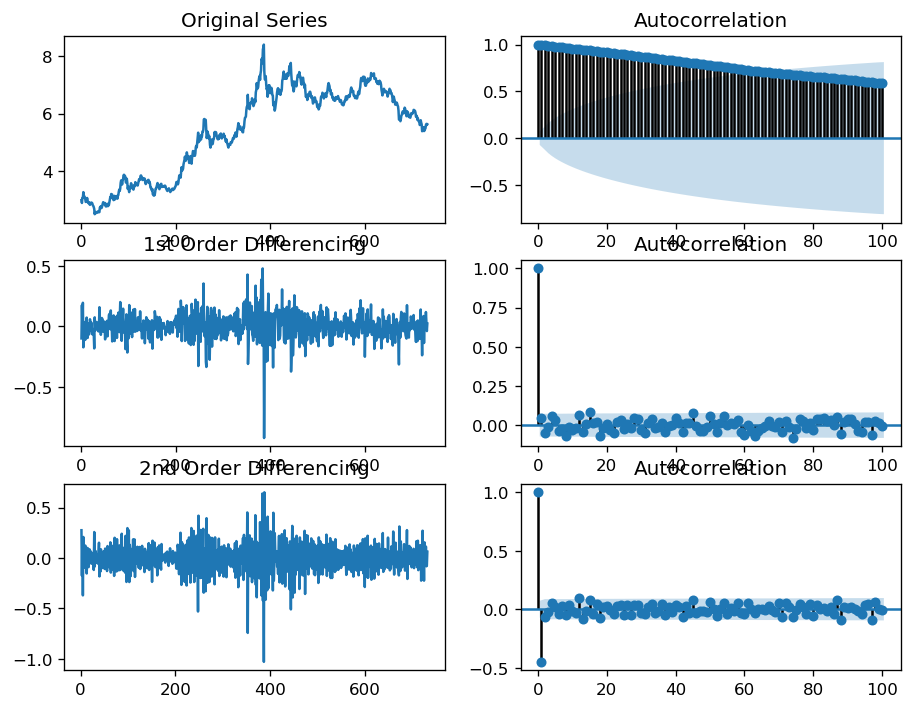

In [2]:
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)
axes[0, 0].plot(df.value); axes[0, 0].set_title('Original Series')
plot_acf(df.value, ax=axes[0, 1], lags=100)

# 1st Differencing
axes[1, 0].plot(df.value.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df.value.diff().dropna(), ax=axes[1, 1], lags=100)

# 2nd Differencing
axes[2, 0].plot(df.value.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df.value.diff().diff().dropna(), ax=axes[2, 1], lags=100)

plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

So, I am going to tentatively fix the order of differencing as 1 even though the series is not perfectly stationary (weak stationarity).

Various arima tests for n differencing:

In [3]:
from pmdarima.arima.utils import ndiffs
y = df.value

## Adf Test
print(ndiffs(y, test='adf'))  # 2

# KPSS test
print(ndiffs(y, test='kpss'))  # 0

# PP test:
ndiffs(y, test='pp')  # 2

1
1


1

# How to find the order of the AR term (p)

The next step is to identify if the model needs any AR terms. You can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

But what is PACF?

Partial autocorrelation can be imagined as the correlation between the series and its lag, after excluding the contributions from the intermediate lags. So, PACF sort of conveys the pure correlation between a lag and the series. That way, you will know if that lag is needed in the AR term or not.

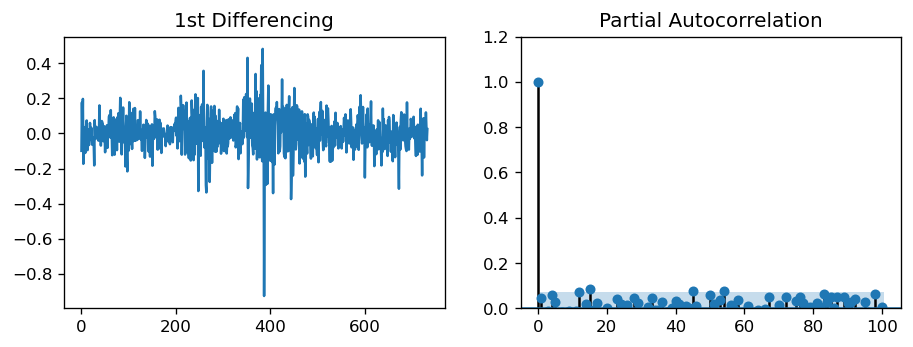

In [4]:
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_pacf(df.value.diff().dropna(), ax=axes[1], lags=100)

plt.show()

We can see the only value outside the expected range on our PACF is the first value, for the most part. This is expected.

# How to find the order of the MA term (q)

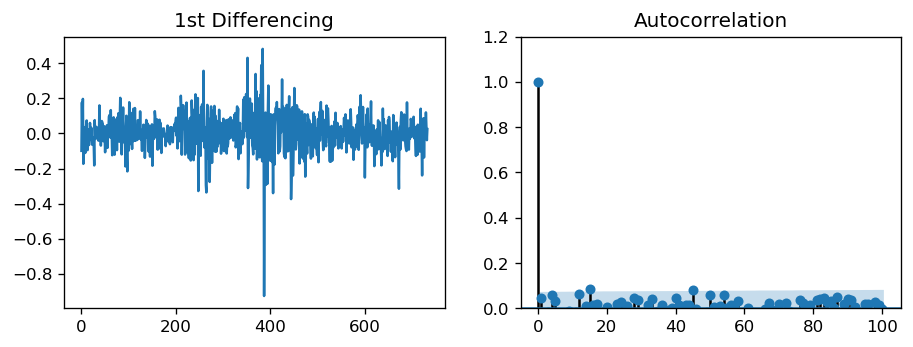

In [5]:
# Import data

fig, axes = plt.subplots(1, 2, sharex=False)
axes[0].plot(df.value.diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,1.2))
plot_acf(df.value.diff().dropna(), ax=axes[1], lags=100)

plt.show()

Same is true for our ACF.  this tells us a ARIMA(1,1,1) model should suffice.

# Building an ARIMA model

In [6]:
from statsmodels.tsa.arima_model import ARIMA

# 1,1,1 ARIMA Model
model = ARIMA(df.value, order=(1,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.value   No. Observations:                  732
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 584.311
Method:                       css-mle   S.D. of innovations              0.109
Date:                Sat, 19 Sep 2020   AIC                          -1160.622
Time:                        17:21:58   BIC                          -1142.239
Sample:                             1   HQIC                         -1153.530
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0036      0.004      0.855      0.393      -0.005       0.012
ar.L1.D.value    -0.3251      0.410     -0.794      0.427      -1.128       0.478
ma.L1.D.value     0.3780      0.400     

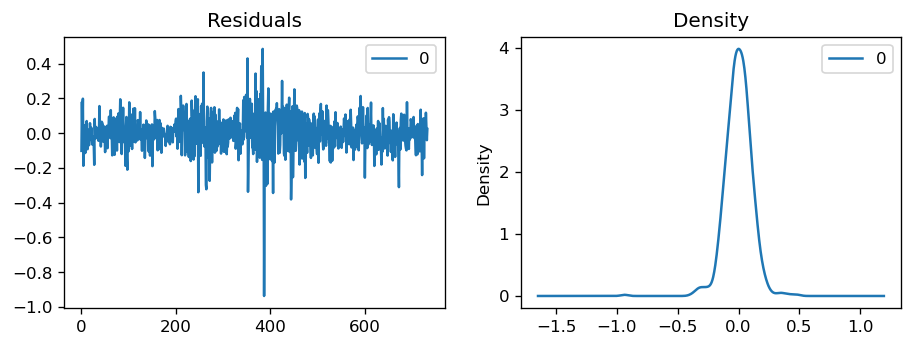

In [7]:
# Plot residual errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

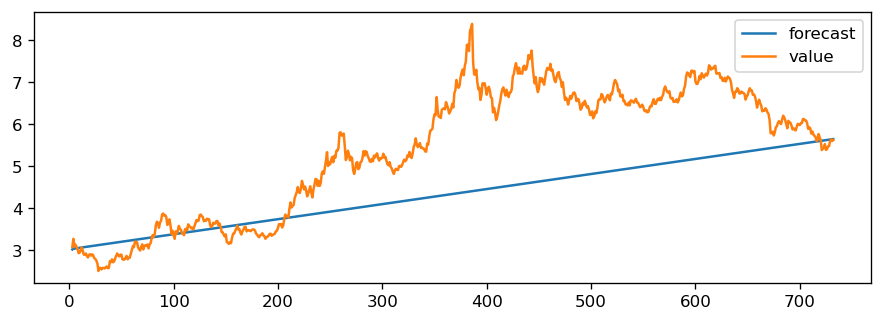

In [8]:
# Actual vs Fitted
model_fit.plot_predict(dynamic=True)
plt.show()

We can set dynamic=True to simulate multi step predictions on the training set to can an idea of how our model does.

# Forecast

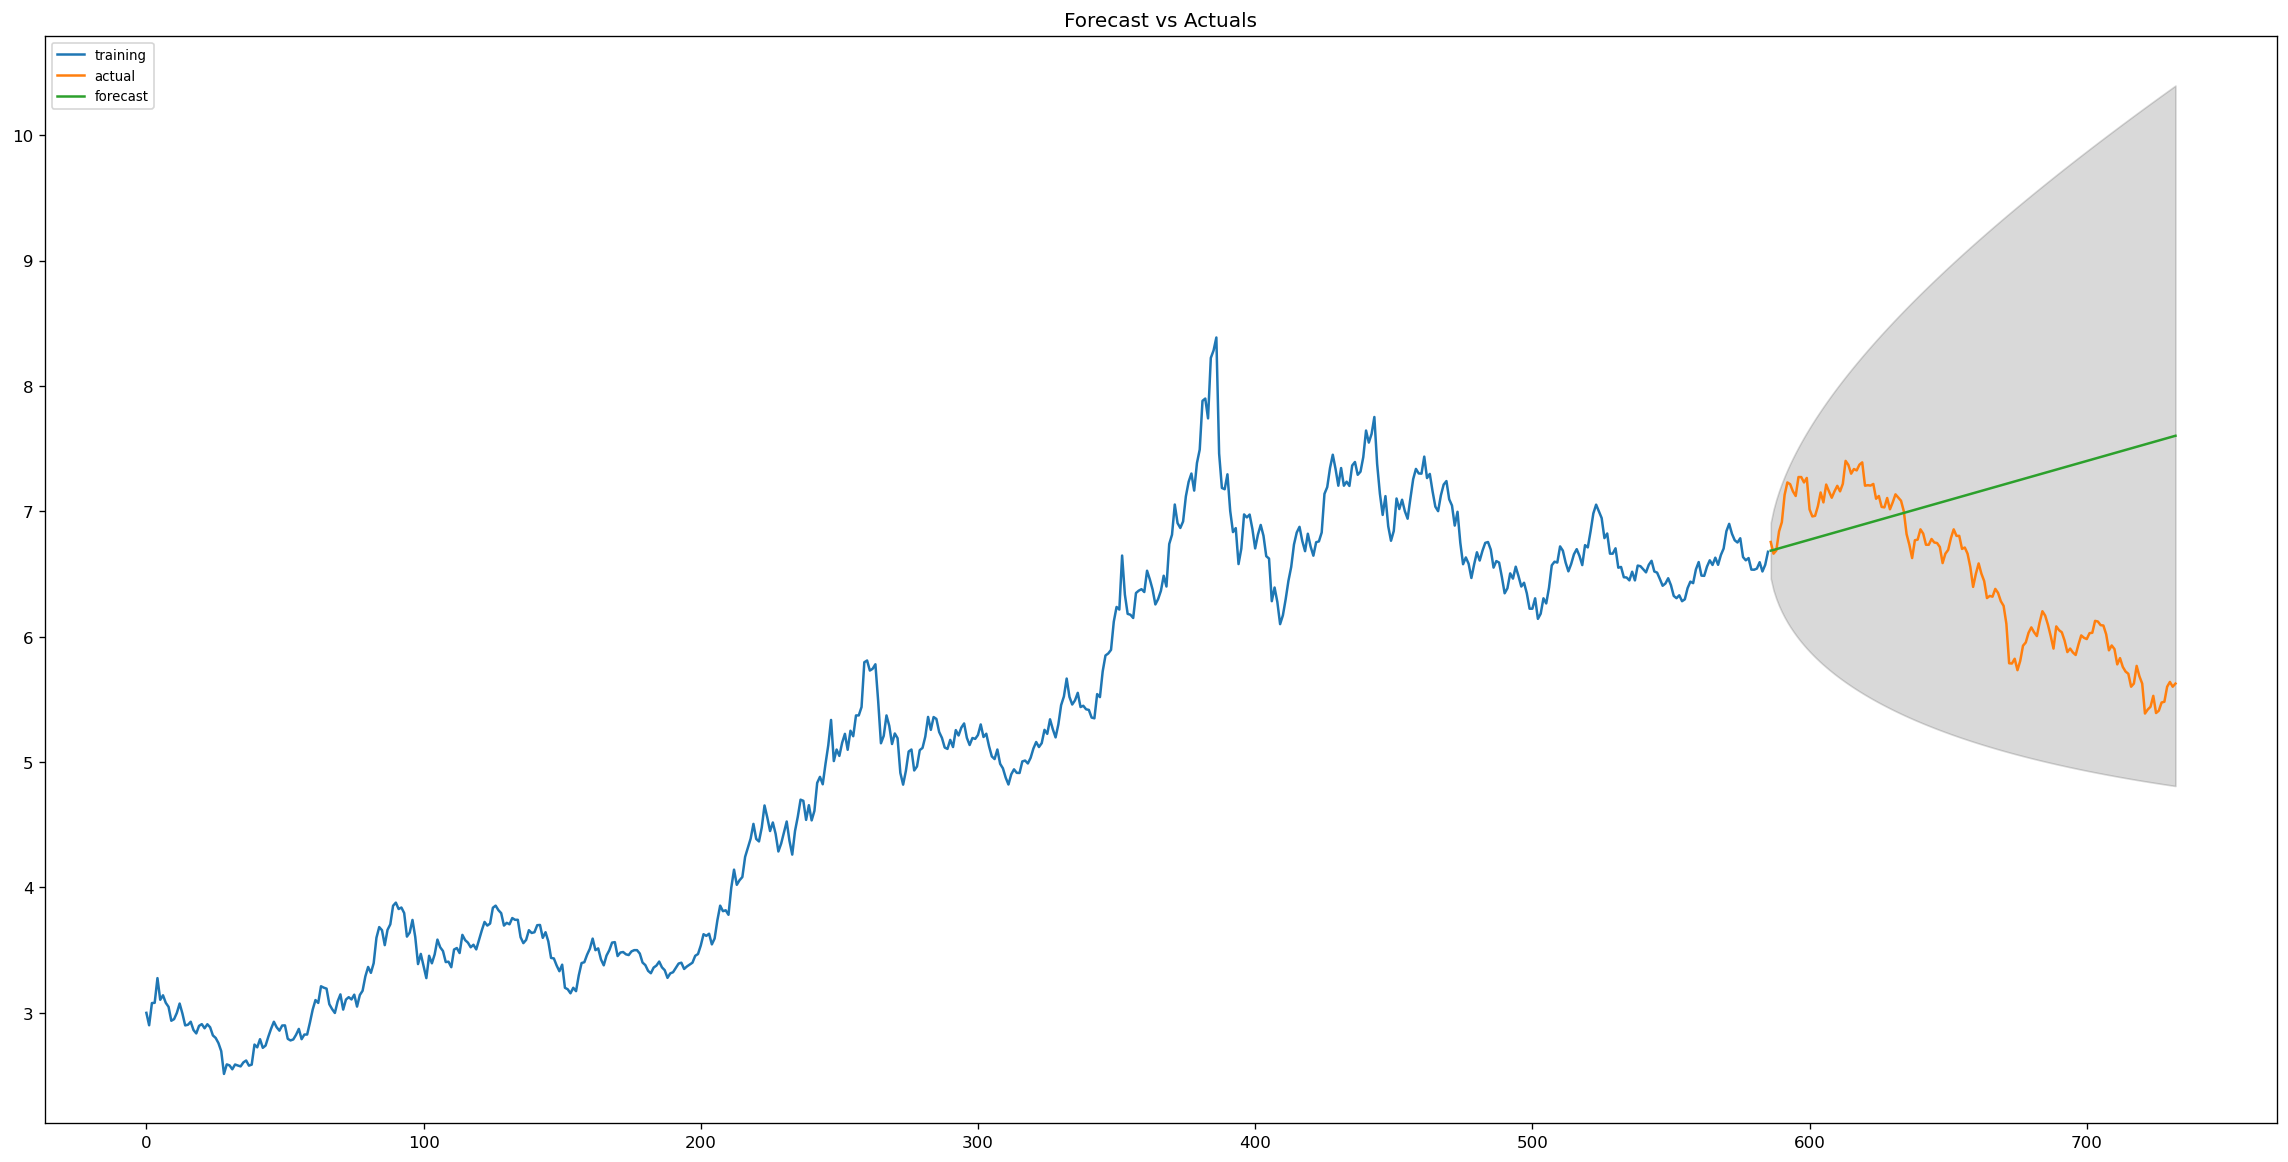

In [9]:
from statsmodels.tsa.stattools import acf

# # Create Training and Test
train, test = data_split(df, .8)
train = train.value
test = test.value
fh = test.size

# Build Model
model = ARIMA(train, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(fh, alpha=0.05)  # 80% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(24,12))
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

# Predict on all date, including the most recent data held out for testing. 

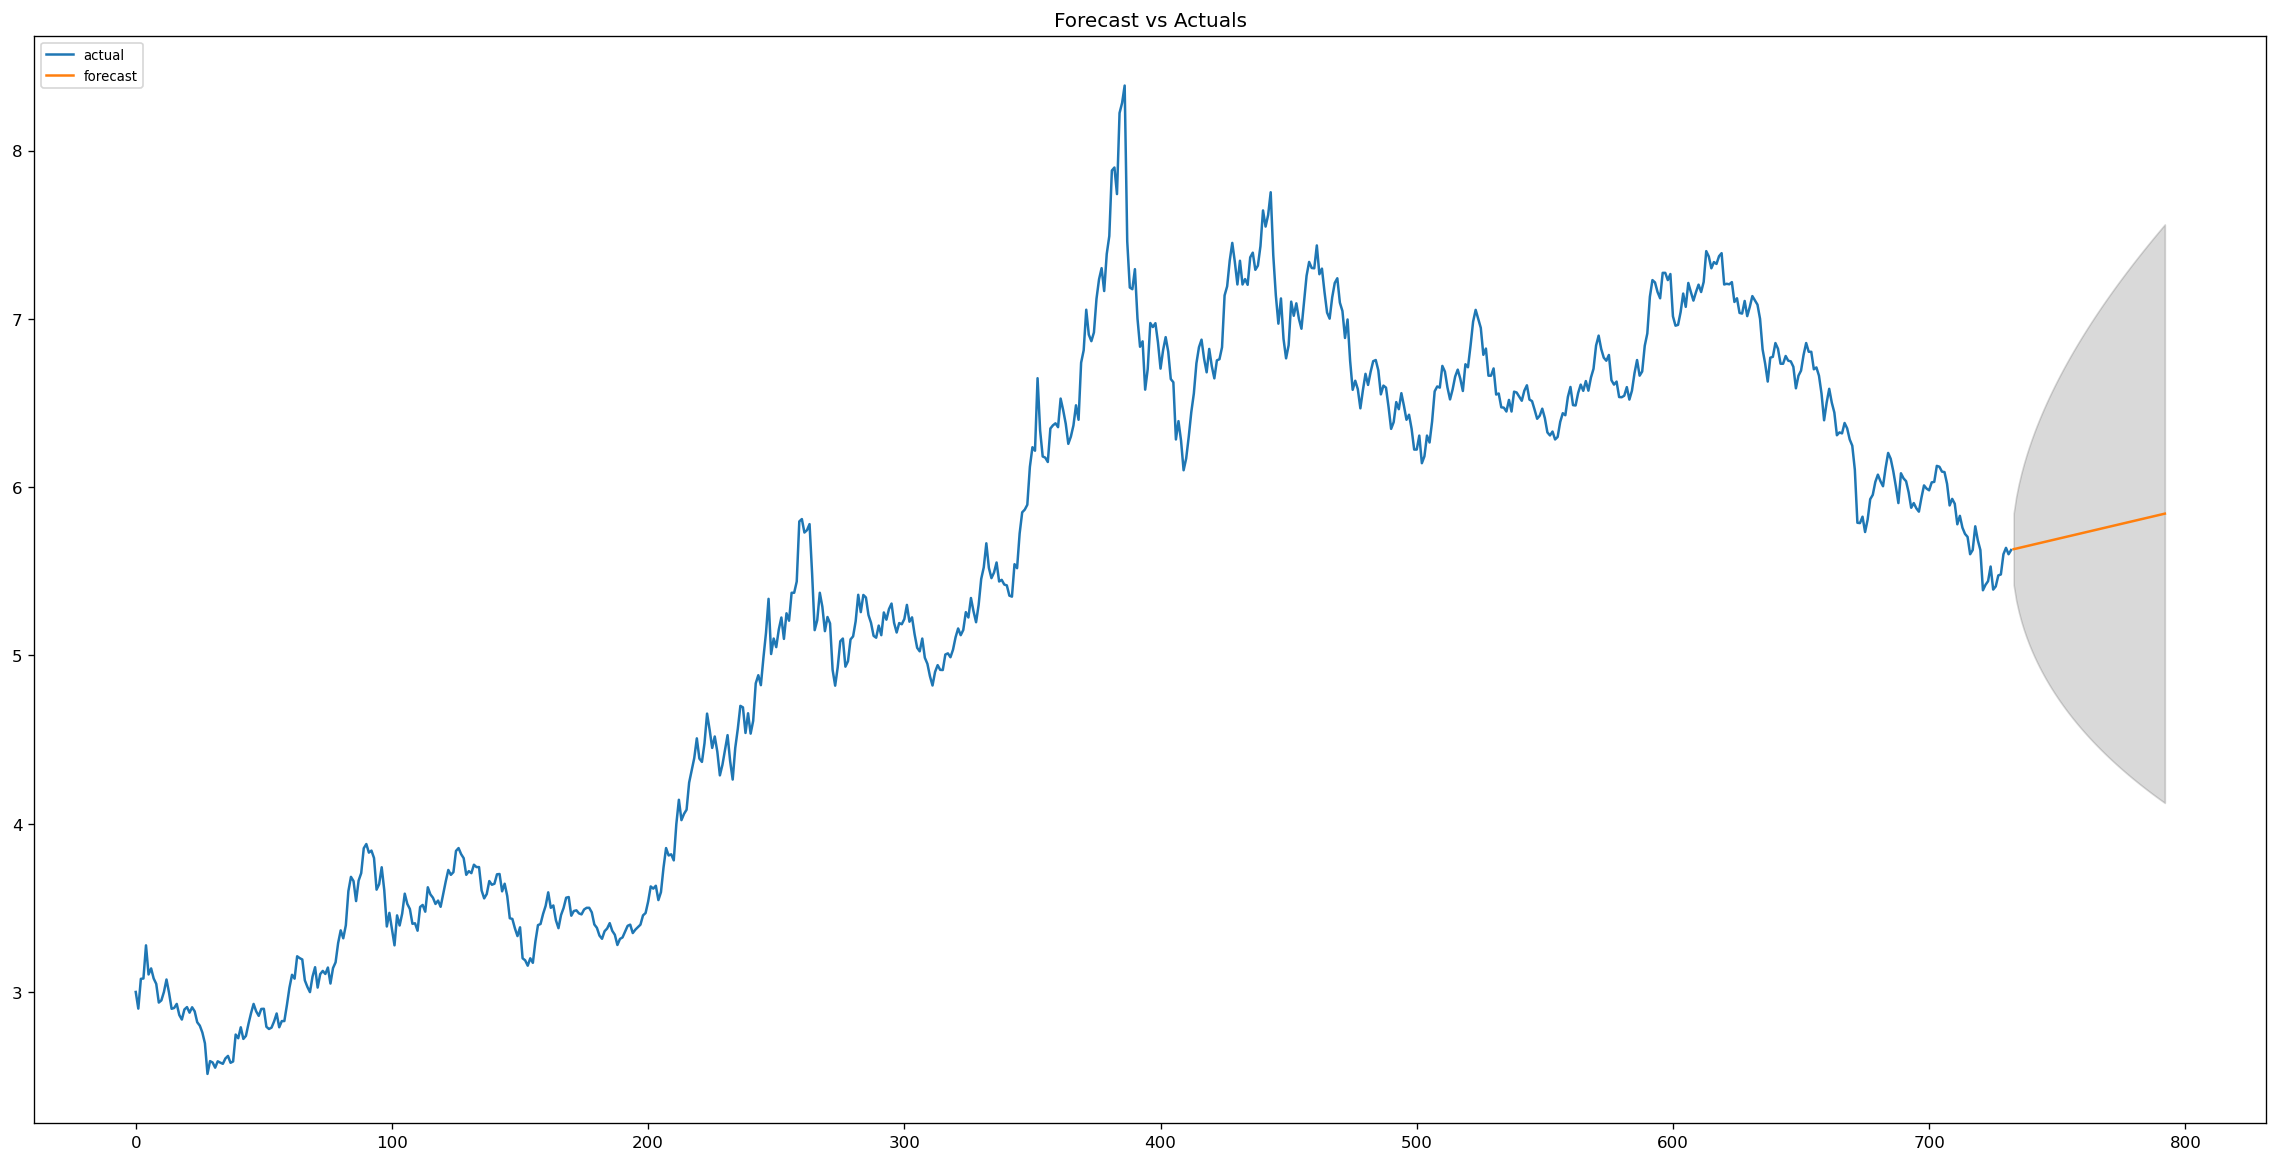

In [10]:
# # Create Training and Test
fh = 60
size = df.value.size

# Build Model
model = ARIMA(df.value, order=(1, 1, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(fh, alpha=0.05)  # 80% conf
index = np.arange(size, size+fh)

# Make as pandas series
fc_series = pd.Series(fc, index=index)
lower_series = pd.Series(conf[:, 0], index=index)
upper_series = pd.Series(conf[:, 1], index=index)

# Plot
plt.figure(figsize=(24,12))
plt.plot(df.value, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()